In [1]:
import bayesian_nn_autoencoder as bae
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


import pandas as pd
from sklearn.preprocessing import StandardScaler

## Helper methods

In [2]:
def reduce_connectome(connectome):
    n_subjects = connectome.shape[0]
    group_ICA_dim = int(np.sqrt(connectome.shape[1]))
    reduced_connectome = np.zeros((n_subjects,group_ICA_dim*(group_ICA_dim-1)/2))
    upper_tri_indices = np.triu_indices(group_ICA_dim,k=1)
    for i in range(n_subjects):
        subject = np.reshape(connectome[i,:],(group_ICA_dim,group_ICA_dim))
        reduced_connectome[i,:] = subject[upper_tri_indices]
    return reduced_connectome

In [3]:
from tensorflow.contrib import distributions
def get_treatment_nontreatment_groups(data):
    nontreatment = data[data['TreatmentGroup'] == 'Sham Exc+Sham cognitive']
    nontreatment_index = nontreatment.index.values
    
    treatment = data[data['TreatmentGroup'] != 'Sham Exc+Sham cognitive']
    treatment_index = treatment.index.values
    
    treatment_class = pd.get_dummies(data['TreatmentGroup'])
    
    return nontreatment_index, treatment_index, np.argmax(np.array(treatment_class),axis = 1)

In [4]:
def plot_study_result(X,Y):
    zero_class = np.where(Y[:, 0])
    one_class = np.where(Y[:, 1])
    two_class = np.where(Y[:, 2])
    three_class = np.where(Y[:, 3])
    
    plt.scatter(X[:, 0], X[:, 1], s=40, c='gray')
    one= plt.scatter(X[zero_class, 0], X[zero_class, 1], s=160, edgecolors='b',
                   facecolors='none', linewidths=2, label='Class C+R_Sham')
    two = plt.scatter(X[one_class, 0], X[one_class, 1], s=80, edgecolors='orange',
                   facecolors='none', linewidths=2, label='Class R+C')
    three =plt.scatter(X[two_class, 0], X[two_class, 1], s=160, edgecolors='red',
                   facecolors='none', linewidths=2, label='Class R+C_Sham')
    four = plt.scatter(X[three_class, 0], X[three_class, 1], s=80, edgecolors='green',
                   facecolors='none', linewidths=2, label='Class Double Shammy')
    plt.legend(handles=[one,two,three,four])

# The data

In [5]:
BL_data = pd.read_excel('/home/hngu4068/Documents/SMART_STUDY/SMART_MasterDatabase_CCA.xlsx',sheetname = 2)
BL_data.head()

,TreatmentGroup,ParticipantStudyID,Ageyears,EducationYrs,TotalInformantBayerIADLscore_612,ParticipantSubjectiveMemoryConcernTotalScore_612,CDRSum_612,SUMofmemorytrials_612,ADASCOGTotalScore_612,MMSEUncorrectedScore_612,...,rh_rostralmiddlefrontal_thickness,rh_superiorfrontal_thickness,rh_superiorparietal_thickness,rh_superiortemporal_thickness,rh_supramarginal_thickness,rh_frontalpole_thickness,rh_temporalpole_thickness,rh_transversetemporal_thickness,rh_insula_thickness,rh_MeanThickness_thickness
0,Sham Exc+Sham cognitive,2,70.59,19,1.115,.,2.0,17.0,12.0,.,...,2.197,2.599,1.944,2.459,2.219,2.262,3.581,1.883,2.790,2.27350
1,Resistance training+ Sham cognitive,3,65.62,19,1.153,.,0.5,23.0,6.6,.,...,2.341,2.607,2.002,2.680,2.302,2.655,3.291,2.285,2.738,2.36391
2,Cognitive training+Sham exc,4,78.96,14,1.000,.,4.5,15.0,15.3,.,...,2.357,2.546,2.008,2.671,2.374,2.507,3.827,2.376,2.887,2.37256
3,Resistance training + Cognitive training,6,65.70,14,1.346,.,0.0,24.0,6.0,.,...,2.205,2.503,2.193,2.642,2.519,2.320,3.375,2.449,2.868,2.33653
4,Resistance training+ Sham cognitive,7,70.92,20,3.615,.,0.0,24.0,6.6,.,...,2.250,2.765,2.202,2.619,2.484,2.509,3.248,2.189,2.680,2.42852


In [6]:
BL_nontreatment, BL_treatment, BL_treatment_class = get_treatment_nontreatment_groups(BL_data)

In [7]:
cog_headings = BL_data.columns.values
cog_headings = cog_headings[4:]
BL_neuro_scores = BL_data[cog_headings]
BL_neuro_scores = BL_neuro_scores.fillna(0)
BL_neuro_scores= BL_neuro_scores.replace('.', 0, regex=True)
#BL_neuro_scores['TotalDrinksperweek_BL'] = pd.to_numeric(BL_neuro_scores['TotalDrinksperweek_BL'])
BL_neuro_scores.head()
BL_neuro_scores = np.array(BL_neuro_scores,dtype=float)

In [8]:
BL_connectome = np.loadtxt('/home/hngu4068/Documents/SMART_STUDY/NET_FU1.txt')
reduced_BL_connectome = np.array(reduce_connectome(BL_connectome),dtype=float)

# Train the data

In [10]:
# create the k fold cross validation sets
regulariser = [0.0,1e-4,1e-3,1e-2,1e-1,1e0]
from sklearn.model_selection import KFold
n_splits = 10
kf = KFold(n_splits=n_splits,random_state = 42,shuffle=True)
n_epoch = 300

test_ELBO = np.zeros((len(regulariser),n_epoch))

i = 0
for ele in regulariser:
    print("training for regulariser %d" %ele)
    for train, test in kf.split(BL_neuro_scores):
        neuro_scaler = StandardScaler()
        X_train = neuro_scaler.fit_transform(BL_neuro_scores[train])
        X_test = neuro_scaler.transform(BL_neuro_scores[test])

        connectome_scaler = StandardScaler()

        Y_train = connectome_scaler.fit_transform(reduced_BL_connectome[train])
        Y_test = connectome_scaler.transform(reduced_BL_connectome[test])

        label_train = BL_treatment_class[train]
        label_test = BL_treatment_class[test]
        
        print("training for training set beginning with index %d" %train[0])
        bae_model = bae.bayesian_autoencoder(X_train,Y_train, 
                                         regulariser_coeff = ele,n_epoch = n_epoch,disp = 50,n_hidden = 50,latent_dim = 2,
                                        learning_rate_initial = 0.01)

        bae_model.train(X_test,Y_test)
        
        test_ELBO[i,:] += bae_model.avg_loss_test_array
        
    test_ELBO[i,:] = test_ELBO[i,:]/n_splits 
    i+=1

training for regulariser 0
training for training set beginning with index 1
log p(x) >= -2192.858
test log p(x) >= -2163.250
log p(x) >= -1820.723
test log p(x) >= -2154.691
log p(x) >= -1786.783
test log p(x) >= -2333.008
log p(x) >= -1711.729
test log p(x) >= -3028.200
log p(x) >= -1679.434
test log p(x) >= -4684.097
log p(x) >= -1627.248
test log p(x) >= -32152.365
training for training set beginning with index 0
log p(x) >= -2193.568
test log p(x) >= -2104.889
log p(x) >= -1828.920
test log p(x) >= -2068.928
log p(x) >= -1764.231
test log p(x) >= -3946.030
log p(x) >= -1716.565
test log p(x) >= -37474.926
log p(x) >= -1699.181
test log p(x) >= -32175.654
log p(x) >= -1670.762
test log p(x) >= -262688.375
training for training set beginning with index 0
log p(x) >= -2193.469
test log p(x) >= -2322.260
log p(x) >= -1834.404
test log p(x) >= -2134.032
log p(x) >= -1772.218
test log p(x) >= -2405.897
log p(x) >= -1774.465
test log p(x) >= -2950.638
log p(x) >= -1713.993
test log p(x) >

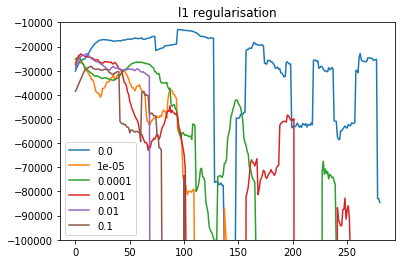

In [42]:
i = 0
for ele in regulariser[:6]:
    temp = np.convolve(test_ELBO[i,:], np.ones(20)/20, mode='valid')
    plt.plot(range(0,n_epoch-19),temp,label = ele)
    plt.ylim(ymin = -100000,ymax = -10000)
    plt.legend()
    plt.title('l1 regularisation')
    i+=1

In [59]:
# create the k fold cross validation sets
regulariser = [0.0,1e-4,1e-3,1e-2,1e-1,1e0,1e10]
from sklearn.model_selection import KFold
n_splits = 10
kf = KFold(n_splits=n_splits,random_state = 42,shuffle=True)
n_epoch = 300

l2_test_ELBO = np.zeros((len(regulariser),n_epoch))

i = 0
for ele in regulariser:
    print("training for regulariser %0.4f" %ele)
    for train, test in kf.split(BL_neuro_scores):
        neuro_scaler = StandardScaler()
        X_train = neuro_scaler.fit_transform(BL_neuro_scores[train])
        X_test = neuro_scaler.transform(BL_neuro_scores[test])

        connectome_scaler = StandardScaler()

        Y_train = connectome_scaler.fit_transform(reduced_BL_connectome[train])
        Y_test = connectome_scaler.transform(reduced_BL_connectome[test])

        label_train = BL_treatment_class[train]
        label_test = BL_treatment_class[test]
        
        print("training for training set beginning with index %d" %train[0])
        bae_model = bae.bayesian_autoencoder(X_train,Y_train, 
                                         regulariser_coeff = ele,n_epoch = n_epoch,disp = 50,n_hidden = 50,latent_dim = 2,
                                        learning_rate_initial = 0.01,regulariser_type = 'l2')

        bae_model.train(X_test,Y_test)
        
        l2_test_ELBO[i,:] += bae_model.avg_loss_test_array
        
    l2_test_ELBO[i,:] = l2_test_ELBO[i,:]/n_splits 
    i+=1

training for regulariser 0.0000
training for training set beginning with index 1
log p(x) >= -2193.239
test log p(x) >= -2161.279
log p(x) >= -1830.917
test log p(x) >= -2118.013
log p(x) >= -1764.441
test log p(x) >= -2784.120
log p(x) >= -1707.507
test log p(x) >= -2740.030
log p(x) >= -1652.964
test log p(x) >= -5894.006
log p(x) >= -1598.662
test log p(x) >= -9073.652
training for training set beginning with index 0
log p(x) >= -2193.356
test log p(x) >= -2105.458
log p(x) >= -1823.219
test log p(x) >= -2756.318
log p(x) >= -1775.170
test log p(x) >= -624721.562
log p(x) >= -1768.361
test log p(x) >= -355461.938
log p(x) >= -1681.653
test log p(x) >= -1888854.000
log p(x) >= -1647.322
test log p(x) >= -1403197.500
training for training set beginning with index 0
log p(x) >= -2187.785
test log p(x) >= -2312.898
log p(x) >= -1824.123
test log p(x) >= -2198.721
log p(x) >= -1773.422
test log p(x) >= -2613.377
log p(x) >= -1737.350
test log p(x) >= -5361.562
log p(x) >= -1712.973
test 

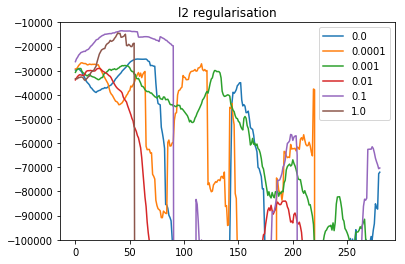

In [60]:
i = 0
for ele in regulariser[:6]:
    temp = np.convolve(l2_test_ELBO[i,:], np.ones(20)/20, mode='valid')
    plt.plot(range(0,n_epoch-19),temp,label = ele)
    plt.ylim(ymin = -100000,ymax = -10000)
    plt.legend()
    plt.title('l2 regularisation')
    i+=1

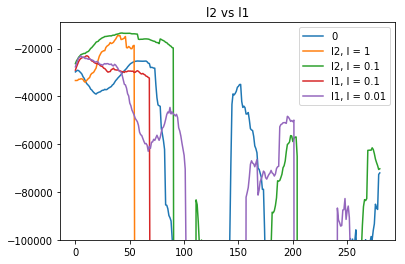

In [61]:
temp = np.convolve(l2_test_ELBO[0,:], np.ones(20)/20, mode='valid')
plt.plot(range(0,n_epoch-19),temp,label = '0')
temp = np.convolve(l2_test_ELBO[5,:], np.ones(20)/20, mode='valid')
plt.plot(range(0,n_epoch-19),temp,label = 'l2, l = 1')
temp = np.convolve(l2_test_ELBO[4,:], np.ones(20)/20, mode='valid')
plt.plot(range(0,n_epoch-19),temp,label = 'l2, l = 0.1')
temp = np.convolve(test_ELBO[4,:], np.ones(20)/20, mode='valid')
plt.plot(range(0,n_epoch-19),temp,label = 'l1, l = 0.1')
temp = np.convolve(test_ELBO[3,:], np.ones(20)/20, mode='valid')
plt.plot(range(0,n_epoch-19),temp,label = 'l1, l = 0.01')
plt.ylim(ymin = -100000,ymax = -9000)
plt.legend()
plt.title('l2 vs l1')
